In [13]:
import keras
import os
import librosa


import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


from keras.models import Sequential
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [53]:
def get_labels(path):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))    
    return labels, label_indices, to_categorical(label_indices)





In [54]:


def save_data_to_array(path, max_pad_len):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        melspectrogram_vectors = []

        wavfiles = [path + '/' + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        #wavfiles = librosa.util.find_files(db)
        #print(wavfiles)
        x=0
        for wavfile in wavfiles:
            name=label+'_'+str(x)
            melspectrogram = wav2melspectrogram(wavfile, name, max_pad_len=max_pad_len)            
            melspectrogram_vectors.append(melspectrogram)            
            x=x+1
        
        #computing PCA and saving
        
        np.save(label + '.npy', melspectrogram_vectors)
        #y=np.load(label + '.npy')
        #y = sklearn.preprocessing.scale(y)
        #y.mean()
        #model = sklearn.decomposition.PCA(n_components=2, whiten=True)
        #model.fit(y)
        #y = model.transform(y)
        #pd.DataFrame(y).to_csv(VALUE_PATH+'/'+label+'.csv')
        
        
sample_x=[]

def wav2melspectrogram(file_path, name, max_pad_len):
    wave, sr = librosa.load(file_path)
    x = librosa.feature.melspectrogram(wave, sr=sr)
    pad_width = max_pad_len - x.shape[1]
    x = np.pad(x, pad_width=((0, 0), (0, pad_width)), mode='constant')
    #here the dimensions are getting reduced 
    #through PCA decompostion
    x = reduce_dimension(x)
    pd.DataFrame(x).to_csv(VALUE_PATH+'/'+name+'.csv')
    return x

In [55]:
DATA_PATH = r'C:\Users\lenovo_pc\Desktop\CNN_SR\Dataset-v2'
VALUE_PATH = r'C:\Users\lenovo_pc\Desktop\CNN_SR\tSNE_matrix'

# t-Distributed Stochastic Neighbour Embedding (t-SNE)
Like PCA, t-SNE is another dimensionality reduction technique, developed in part by the godfather of machine learning himself, Geoffrey Hinton. Quoting Wikipedia : It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

labels, indices, _ = get_labels(DATA_PATH)

 Getting first arrays
T = np.load(labels[0] + '.npy')
 Getting first element of first array
X = T[127]
print(X.shape)

 Running t-SNE generating 3 dimensional data points
print("Calculating TSNE")
tsne = TSNE(n_components=3, perplexity=40, verbose=2, n_iter=500,early_exaggeration=1)
tsne0 = tsne.fit_transform(X.T)
tsne0 = StandardScaler().fit_transform(tsne0)

print(tsne0.T.shape)


In [56]:
def reduce_dimension(X):
    tsne = TSNE(n_components=6, perplexity=40, verbose=2, n_iter=500,early_exaggeration=1)
    tsne0 = tsne.fit_transform(X.T)
    tsne0 = StandardScaler().fit_transform(tsne0)
    
    return tsne0.T

In [57]:
from sklearn.model_selection import train_test_split


def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    # print(X.shape[0]) returns: 129
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        #print(X.shape[0]) returns: 129+152=281
        #print(i) returns: 0: So all y values are 1 for Seven and 0 for Tin
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)



In [58]:




# Second dimension of the feature is dim2
feature_dim_2 = 22

# Save data to array file first
save_data_to_array(DATA_PATH,feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 128
channel = 1
epochs = 50
batch_size = 100
verbose = 1
num_classes = 2


y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

ValueError: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.

In [30]:

#X_train = np.array(x_train)
print(X_train.shape)
print(X_test.shape)

(224, 3, 22)
(57, 3, 22)


# *********++++++*********++++++*********++++++*********++++++

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

In [34]:
seq_length = 128

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(3,22)))
model.add(Conv1D(64, 1, activation='relu'))
model.add(Conv1D(64, 1, activation='relu'))
model.add(Conv1D(64, 1, activation='relu'))
model.add(MaxPooling1D(1))
model.add(Conv1D(128, 1, activation='relu'))
model.add(Conv1D(128, 1, activation='relu'))
model.add(Conv1D(128, 1, activation='relu'))
model.add(MaxPooling1D(1))
model.add(Conv1D(256, 1, activation='relu'))
model.add(Conv1D(256, 1, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [35]:
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [36]:

history = model.fit(X_train, y_train_hot, batch_size=7, epochs=10, validation_data=(X_test, y_test_hot))

Train on 224 samples, validate on 57 samples
Epoch 1/10
224/224 [==============================] - 4s 20ms/step - loss: 0.6930 - acc: 0.5022 - val_loss: 0.6937 - val_acc: 0.5088
Epoch 2/10
224/224 [==============================] - 0s 925us/step - loss: 0.6926 - acc: 0.5223 - val_loss: 0.6936 - val_acc: 0.5088
Epoch 3/10
224/224 [==============================] - 0s 871us/step - loss: 0.6907 - acc: 0.5536 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 4/10
224/224 [==============================] - 0s 876us/step - loss: 0.6905 - acc: 0.5536 - val_loss: 0.6936 - val_acc: 0.5088
Epoch 5/10
224/224 [==============================] - 0s 880us/step - loss: 0.6898 - acc: 0.5536 - val_loss: 0.6937 - val_acc: 0.5088
Epoch 6/10
224/224 [==============================] - 0s 867us/step - loss: 0.6902 - acc: 0.5513 - val_loss: 0.6938 - val_acc: 0.5088
Epoch 7/10
224/224 [==============================] - 0s 902us/step - loss: 0.6890 - acc: 0.5446 - val_loss: 0.6939 - val_acc: 0.5088
Epoch 8/10
224/224

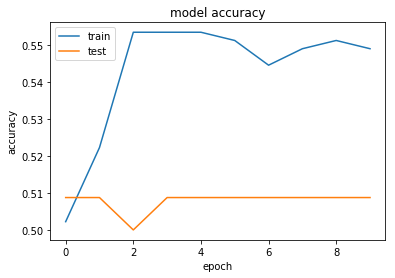

In [37]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


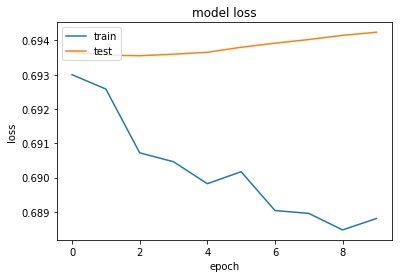

In [38]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# *********++++++*********++++++*********++++++*********++++++

In [42]:
seq_length = 128

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(3,22)))
model.add(Conv1D(64, 1, activation='relu'))
model.add(MaxPooling1D(1))
model.add(Conv1D(128, 1, activation='relu'))
model.add(Conv1D(128, 1, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))


In [43]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [44]:
#model.fit(x_train, y_train, batch_size=7, epochs=10)

history = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 224 samples, validate on 57 samples
Epoch 1/50
224/224 [==============================] - 1s 6ms/step - loss: 0.7045 - acc: 0.5000 - val_loss: 0.6952 - val_acc: 0.5000
Epoch 2/50
224/224 [==============================] - 0s 98us/step - loss: 0.6823 - acc: 0.5513 - val_loss: 0.6958 - val_acc: 0.5088
Epoch 3/50
224/224 [==============================] - 0s 94us/step - loss: 0.6662 - acc: 0.5737 - val_loss: 0.6952 - val_acc: 0.5351
Epoch 4/50
224/224 [==============================] - 0s 103us/step - loss: 0.6569 - acc: 0.6496 - val_loss: 0.6983 - val_acc: 0.5000
Epoch 5/50
224/224 [==============================] - 0s 89us/step - loss: 0.6412 - acc: 0.7121 - val_loss: 0.6927 - val_acc: 0.5088
Epoch 6/50
224/224 [==============================] - 0s 98us/step - loss: 0.6323 - acc: 0.6987 - val_loss: 0.7037 - val_acc: 0.5088
Epoch 7/50
224/224 [==============================] - 0s 112us/step - loss: 0.6099 - acc: 0.6763 - val_loss: 0.7078 - val_acc: 0.5000
Epoch 8/50
224/224 [===

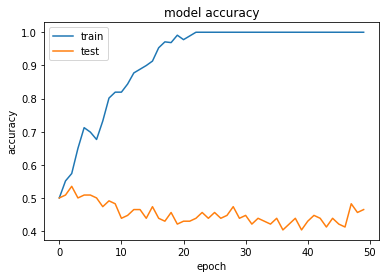

In [45]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

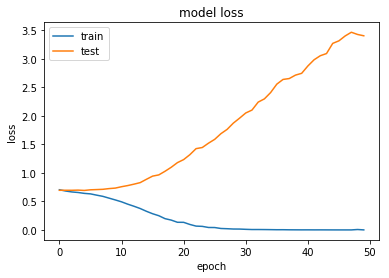

In [46]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# *********++++++*********++++++*********++++++*********++++++

# RNN+LSTM

In [47]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

In [48]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (3,22)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

Build LSTM RNN model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 64)             22272     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 34,754
Trainable params: 34,754
Non-trainable params: 0
_________________________________________________________________


In [49]:
%%time
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=50
MAX_BATCH=7

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(X_train, y_train_hot, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(X_test, y_test_hot),
                  callbacks=callback) 

print ("training finised!")



training started..... please wait.

Epoch 00001: loss improved from inf to 0.68951, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.68951 to 0.67715, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.67715 to 0.67060, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 0.67060 to 0.65990, saving model to ./best_model_trained.hdf5

Epoch 00005: loss improved from 0.65990 to 0.65187, saving model to ./best_model_trained.hdf5

Epoch 00006: loss improved from 0.65187 to 0.64035, saving model to ./best_model_trained.hdf5

Epoch 00007: loss improved from 0.64035 to 0.63425, saving model to ./best_model_trained.hdf5

Epoch 00008: loss improved from 0.63425 to 0.62176, saving model to ./best_model_trained.hdf5

Epoch 00009: loss improved from 0.62176 to 0.60981, saving model to ./best_model_trained.hdf5

Epoch 00010: loss improved from 0.60981 to 0.60190, saving model to ./best_model_trained.hdf5

Epoch 00011: loss 

In [50]:
score = model.evaluate(X_train, y_train_hot, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(X_test, y_test_hot, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

model train data score       :  88.0 %
model test data score        :  61.0 %


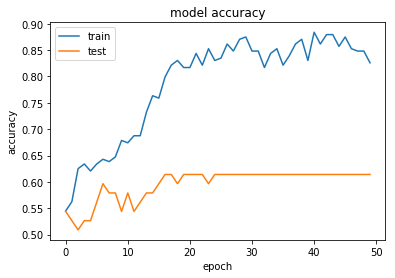

In [51]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

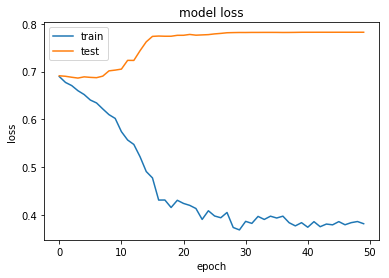

In [52]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()